# <신용카드 고객 분석 및 이탈고객 예측>

고객이 자사 신용카드를 더이상 사용하지 않고 이탈해버리는 것은 은행에서는 큰 비즈니스적 문제이다. 따라서 어떤 요소들이 고객이탈과 관련있는지 파악하고, 이탈을 방지할 수 있는 방안들을 마련할 필요가 있다.

이를 위해 10127개의 고객 데이터를 분석한 뒤, Random Forest와 XGBoost 두 모델을 활용해 어떤 요소들이 고객의 이탈에 가장 관련이 있는지 파악한다.

[가설] <br>
소득이 적을 수록, 카드 등급이 낮을 수록, 카드사용 금액이 적을 수록 이탈 가능성이 높을 것이다.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import show
import warnings
warnings.filterwarnings(action = 'ignore')

# 1. 데이터 확인

In [2]:
df = pd.read_csv('./data/BankChurners/BankChurners.csv')

In [3]:
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,60K - 80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than 40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,80K - 120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than 40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,60K - 80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


### 컬럼 정보

- CLIENTNUM ------------------ 클라이언트 고유번호
- <strong>Attrition_Flag ------------------ 계정이 존재/폐쇄 여부 -> 타겟값</strong>
- Customer_Age --------------- 고객의 연령
- Gender -------------------------- M = 남성, F = 여성
- Dependent_count ------------ 부양 가족 수 
- Education_Level ------------- 계좌 소유자의 최종 학력             
- Marital_Status ---------------- 기혼, 미혼, 이혼, 알 수 없음               
- Income_Category ------------ 계정 소유자의 연간 소득 범주
- Card_Category --------------- 카드 유형 (블루, 실버, 골드, 플래티넘)         
- Months_on_book ------------- 은행과의 거래 기간(월)
- Total_Relationship_Count -- 고객이 보유한 카드 수
- Months_Inactive_12_mon -- 지난 12 개월 동안 비활성 상태인 개월 수
- Contacts_Count_12_mon -- 지난 12 개월 동안의 연락 횟수      
- Credit_Limit -------------------- 신용 카드 신용 한도
- Total_Revolving_Bal --------- 신용 카드의 총 잔액         
- Avg_Open_To_Buy ---------- 신용 한도 구매 가능 금액 (지난 12 개월 평균)
- Total_Amt_Chng_Q4_Q1 -- 거래 금액의 변동 (Q1 대비 Q4)
- Total_Trans_Amt ------------- 총 거래 금액 (지난 12 개월)
- Total_Trans_Ct --------------- 총 거래 수 (지난 12 개월)    
- Total_Ct_Chng_Q4_Q1 ---- 거래 건수 변경 (Q1 대비 Q4)   
- Avg_Utilization_Ratio ------- 평균 카드 사용률

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

데이터는 10127개의 행과 21개의 열로 이루어져 있다.

In [5]:
# NaN 값이 있는지 확인
df.isnull().sum()

CLIENTNUM                   0
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

# 2. EDA

In [6]:
from matplotlib import font_manager, rc
import platform

# 이미지에 한글 표시 설정
if platform.system() == 'Windows': # 윈도우인 경우 맑은고딕
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else :  # Mac인 경우 애플고딕
    rc('font', family='AppleGothic')

# 그래프에서 마이너스 기호가 표시되도록 하는 설정
matplotlib.rcParams['axes.unicode_minus'] = False

## 2.1. 범주형 데이터 EDA

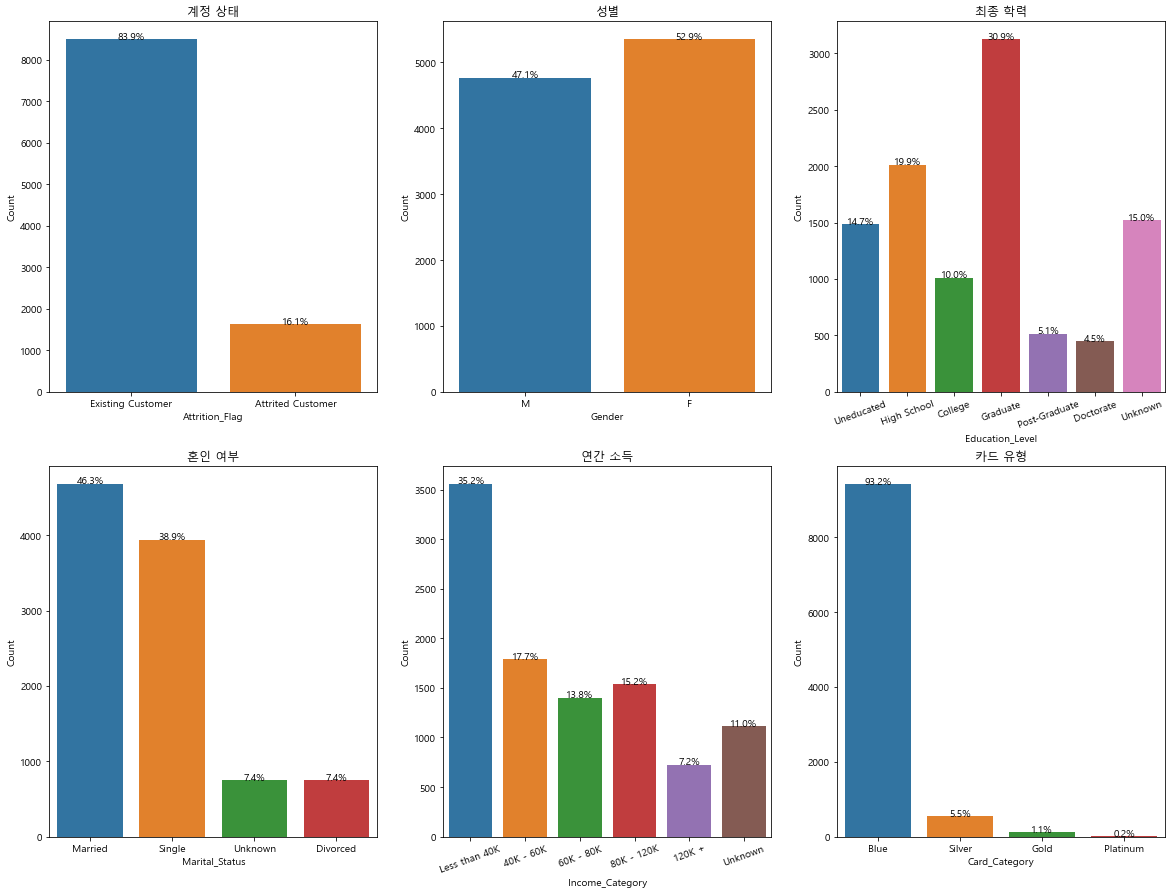

In [7]:
# 각 변수에 알리아스를 지정해서 그래프 그리기
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.countplot(data=df, x='Attrition_Flag', ax=ax1)
sns.countplot(data=df, x='Gender', ax=ax2)
sns.countplot(data=df, x='Education_Level', ax=ax3,
              order=["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate", "Unknown"])
sns.countplot(data=df, x='Marital_Status', ax=ax4)
sns.countplot(data=df, x='Income_Category', ax=ax5, 
              order=["Less than 40K", "40K - 60K", "60K - 80K", "80K - 120K", "120K +", "Unknown"])
sns.countplot(data=df, x='Card_Category', ax=ax6,
              order=["Blue", "Silver", "Gold", "Platinum"])

# % 표현
total = float(len(df))
ax = [ax1, ax2, ax3, ax4, ax5, ax6]
for i in ax:
    for p in i.patches:
        height = p.get_height()
        i.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100 * height/total),
                ha="center") 


# 제목 추가
ax1.set(ylabel='Count', title='계정 상태')
ax2.set(ylabel='Count', title='성별')
ax3.set(ylabel='Count', title='최종 학력')
ax4.set(ylabel='Count', title='혼인 여부')
ax5.set(ylabel='Count', title='연간 소득')
ax6.set(ylabel='Count', title='카드 유형')


plt.sca(ax3)
plt.xticks(rotation=20)
plt.sca(ax5)
plt.xticks(rotation=20)

plt.show()

## 2.2. 연속형 데이터 EDA

[Text(0.5, 1.0, '신용 카드의 총 잔액')]

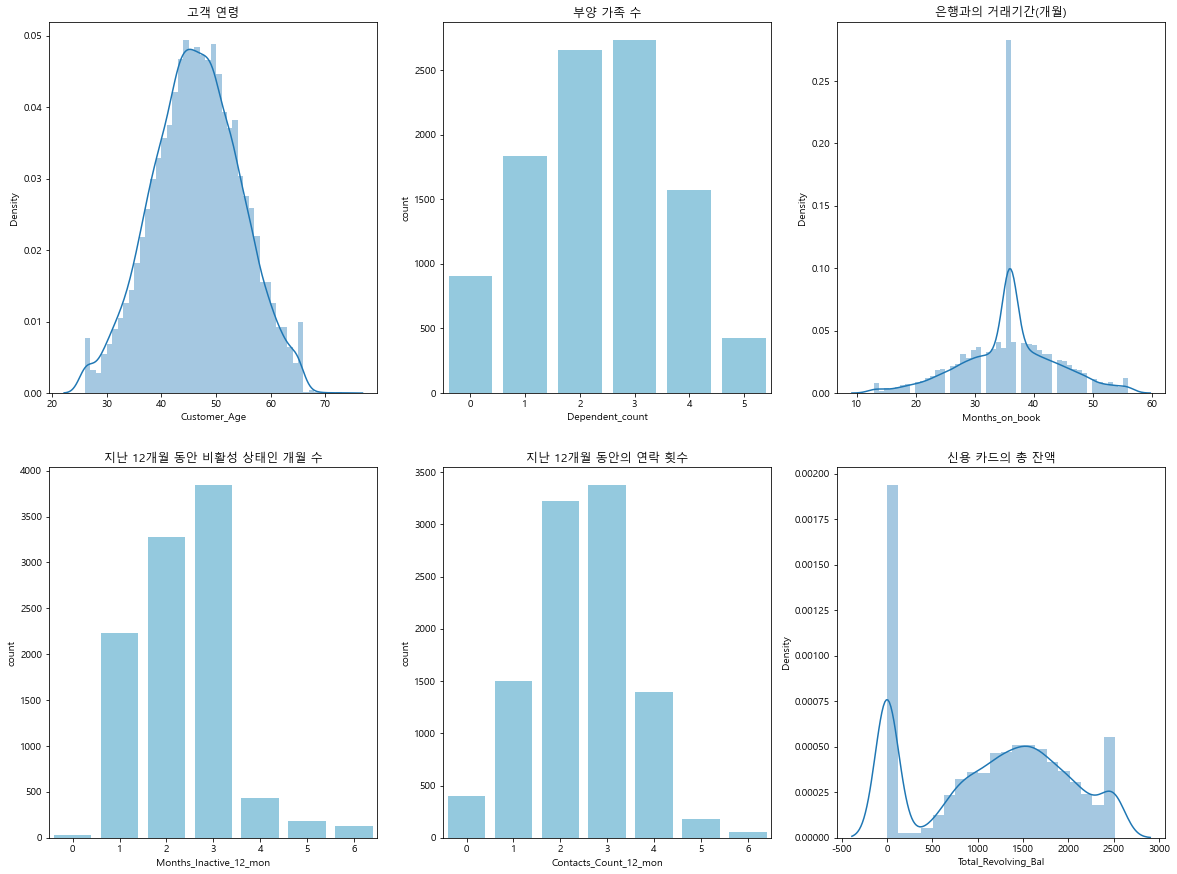

In [8]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.distplot(df['Customer_Age'], ax=ax1)
sns.countplot(data=df, x='Dependent_count', ax=ax2, color="skyblue")
sns.distplot(df['Months_on_book'], ax=ax3)
sns.countplot(data=df, x='Months_Inactive_12_mon', ax=ax4, color="skyblue")
sns.countplot(data=df, x='Contacts_Count_12_mon', ax=ax5, color="skyblue")
sns.distplot(df['Total_Revolving_Bal'], ax=ax6)

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax5.set(title='지난 12개월 동안의 연락 횟수')
ax6.set(title='신용 카드의 총 잔액')

In [9]:
df[['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon']].describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000


<AxesSubplot:xlabel='Months_on_book', ylabel='count'>

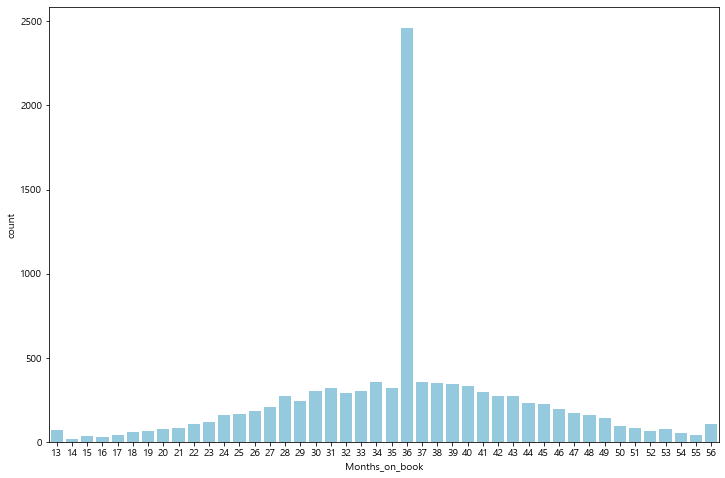

In [10]:
plt.figure(figsize = (12, 8))
sns.countplot(data=df, x='Months_on_book', color="skyblue")

은행과의 거래기간이 36개월인 사람이 압도적으로 많다는 것이 눈에 띈다.

In [11]:
# month_36 = df[df['Months_on_book'] == 36]
# month_36

[Text(0.5, 1.0, '신용 카드의 총 잔액')]

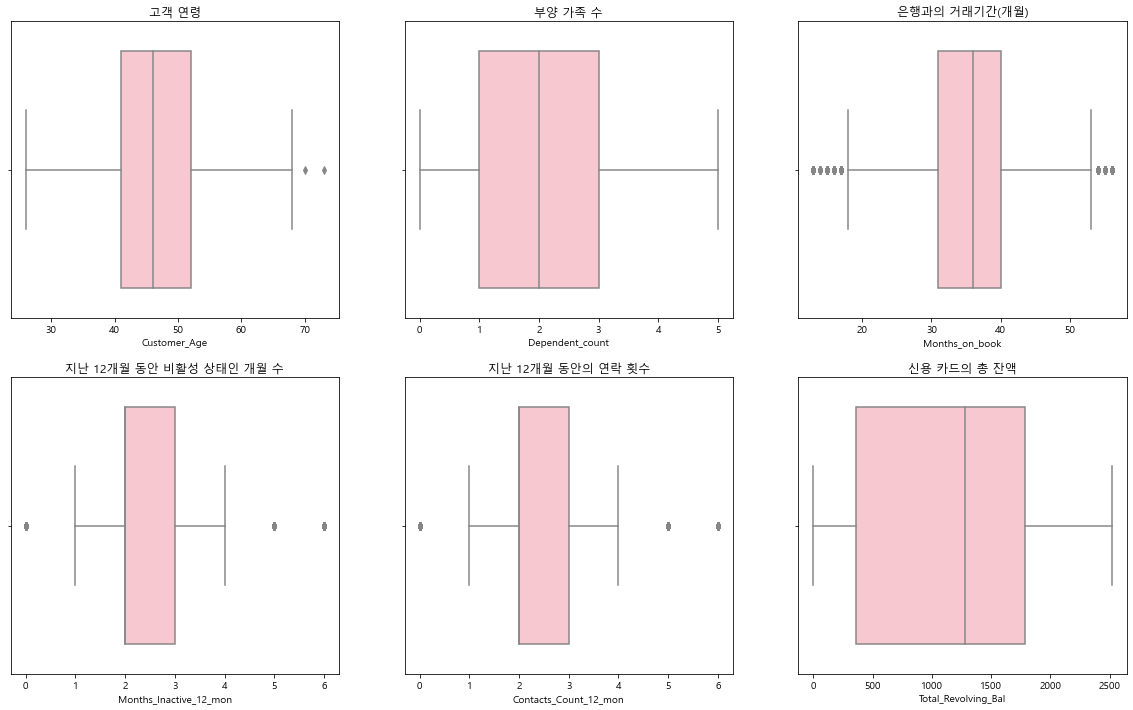

In [12]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,12)

sns.boxplot(data=df, x='Customer_Age', ax=ax1, color="pink")
sns.boxplot(data=df, x='Dependent_count', ax=ax2, color="pink")
sns.boxplot(data=df, x='Months_on_book', ax=ax3, color="pink")
sns.boxplot(data=df, x='Months_Inactive_12_mon', ax=ax4, color="pink")
sns.boxplot(data=df, x='Contacts_Count_12_mon', ax=ax5, color="pink")
sns.boxplot(data=df, x='Total_Revolving_Bal', ax=ax6, color='pink')

ax1.set(title='고객 연령')
ax2.set(title='부양 가족 수')
ax3.set(title='은행과의 거래기간(개월)')
ax4.set(title='지난 12개월 동안 비활성 상태인 개월 수')
ax5.set(title='지난 12개월 동안의 연락 횟수')
ax6.set(title='신용 카드의 총 잔액')

[Text(0.5, 1.0, '평균 카드 사용률')]

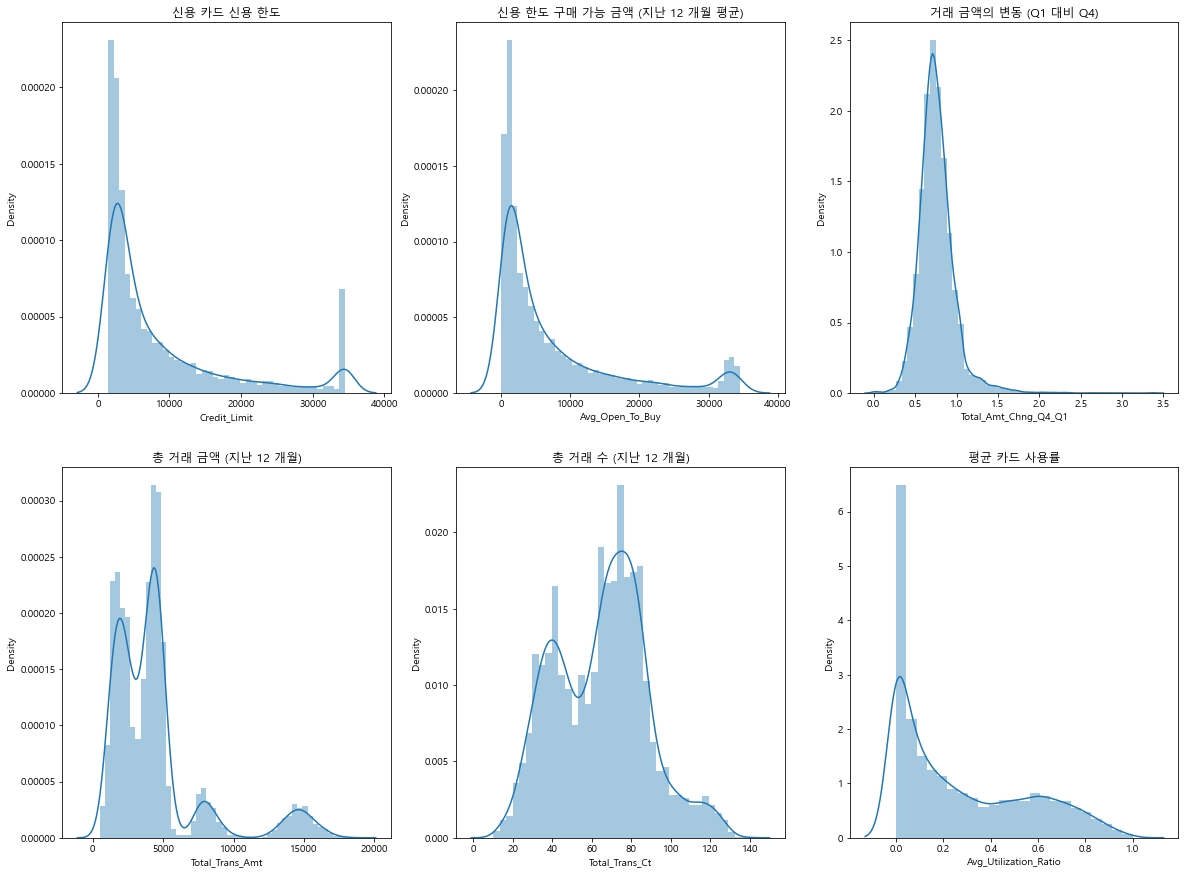

In [13]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.distplot(df['Credit_Limit'], ax=ax1)
sns.distplot(df['Avg_Open_To_Buy'], ax=ax2)
sns.distplot(df['Total_Amt_Chng_Q4_Q1'], ax=ax3)
sns.distplot(df['Total_Trans_Amt'], ax=ax4)
sns.distplot(df['Total_Trans_Ct'], ax=ax5)
sns.distplot(df['Avg_Utilization_Ratio'], ax=ax6)

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax3.set(title='거래 금액의 변동 (Q1 대비 Q4)')
ax4.set(title='총 거래 금액 (지난 12 개월)')
ax5.set(title='총 거래 수 (지난 12 개월)')
ax6.set(title='평균 카드 사용률')

In [14]:
df[['Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct']].describe()

,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695
std,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570
min,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000
25%,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000
50%,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000
75%,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000
max,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000


In [15]:
df['Total_Revolving_Bal'][df['Total_Revolving_Bal'] > 0].describe()

count    7657.000000
mean     1537.915372
std       549.128757
min       132.000000
25%      1132.000000
50%      1524.000000
75%      1935.000000
max      2517.000000
Name: Total_Revolving_Bal, dtype: float64

[Text(0.5, 1.0, '평균 카드 사용률')]

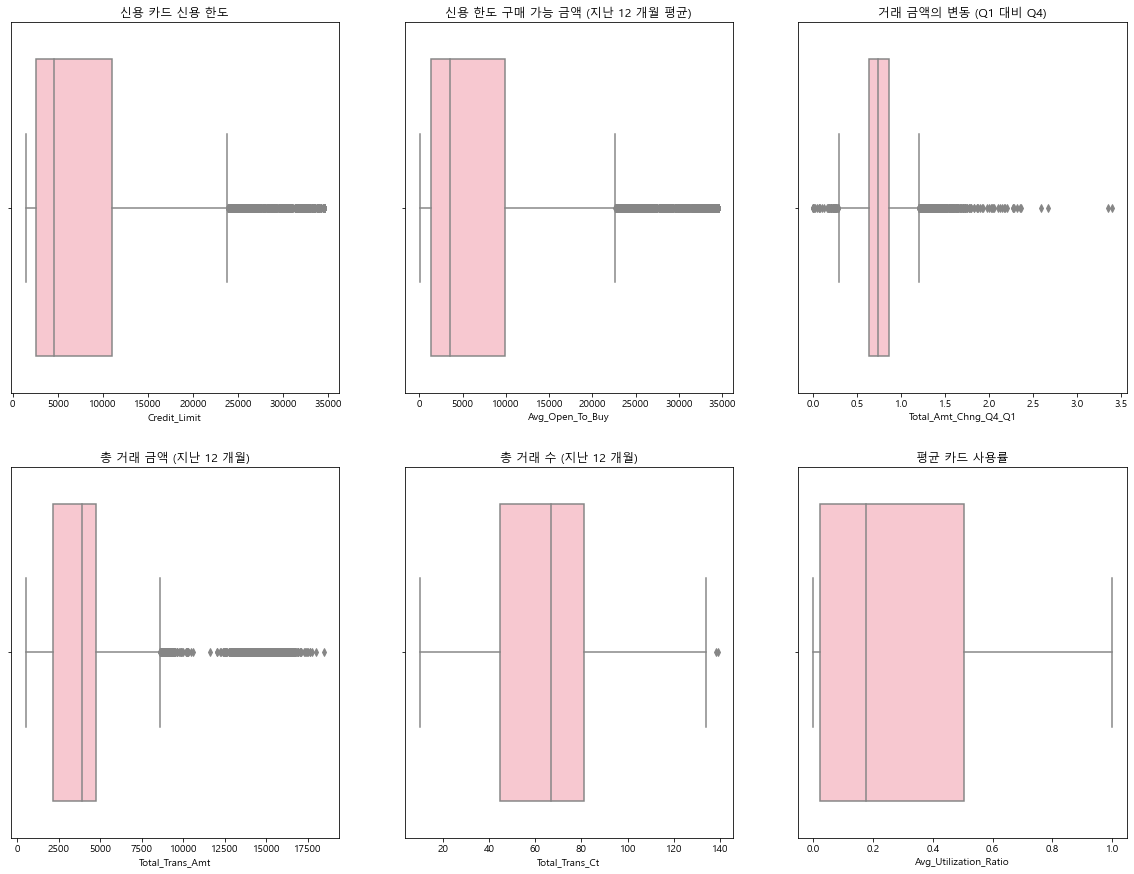

In [16]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(20,15)

sns.boxplot(data=df, x='Credit_Limit', ax=ax1, color='pink')
sns.boxplot(data=df, x='Avg_Open_To_Buy', ax=ax2, color='pink')
sns.boxplot(data=df, x='Total_Amt_Chng_Q4_Q1', ax=ax3, color='pink')
sns.boxplot(data=df, x='Total_Trans_Amt', ax=ax4, color='pink')
sns.boxplot(data=df, x='Total_Trans_Ct', ax=ax5, color='pink')
sns.boxplot(data=df, x='Avg_Utilization_Ratio', ax=ax6, color="pink")

ax1.set(title='신용 카드 신용 한도')
ax2.set(title='신용 한도 구매 가능 금액 (지난 12 개월 평균)')
ax3.set(title='거래 금액의 변동 (Q1 대비 Q4)')
ax4.set(title='총 거래 금액 (지난 12 개월)')
ax5.set(title='총 거래 수 (지난 12 개월)')
ax6.set(title='평균 카드 사용률')

In [17]:
df[df['Total_Amt_Chng_Q4_Q1'] > 3.0]

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8,710930508,Existing Customer,37,M,3,Uneducated,Single,60K - 80K,Blue,36,...,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113
12,710599683,Existing Customer,56,M,1,College,Single,80K - 120K,Blue,36,...,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000


[Text(0.5, 1.0, '거래 건수 변경 (Q1 대비 Q4)')]

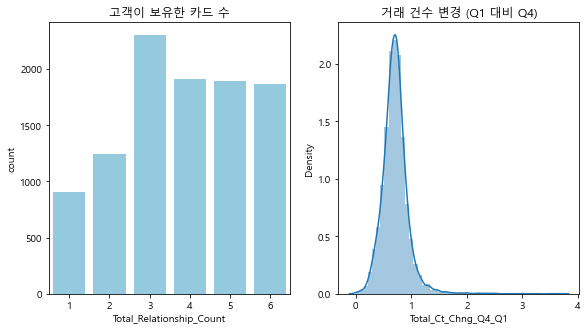

In [18]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(9.5,5)

sns.countplot(data=df, x='Total_Relationship_Count', ax=ax1, color="skyblue")
sns.distplot(df['Total_Ct_Chng_Q4_Q1'], ax=ax2)


ax1.set(title='고객이 보유한 카드 수')
ax2.set(title='거래 건수 변경 (Q1 대비 Q4)')


In [19]:
df[['Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']].describe()

,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000
mean,0.712222,0.274894
std,0.238086,0.275691
min,0.000000,0.000000
25%,0.582000,0.023000
50%,0.702000,0.176000
75%,0.818000,0.503000
max,3.714000,0.999000


[Text(0.5, 1.0, '거래 건수 변경 (Q1 대비 Q4)')]

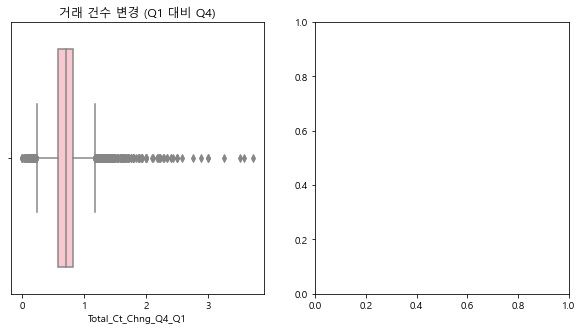

In [20]:
figure, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(10,5)

sns.boxplot(data=df, x='Total_Relationship_Count', ax=ax4, color="pink")
sns.boxplot(data=df, x='Total_Ct_Chng_Q4_Q1', ax=ax1, color="pink")

ax4.set(title='고객이 보유한 카드 수')
ax1.set(title='거래 건수 변경 (Q1 대비 Q4)')

- EDA를 통해 각 변수들을 시각화하여 살펴보고 이상치를 확인했다.
- 이상치들이 더러 있었지만, 비정상적으로 극단적인 이상치(ex, 1000회 이상의 거래 횟수)는 발견되지 않았기에 확인된 이상치는 모두 수용하기로 결정했다.

# 3. 원핫 인코딩(One-Hot Encoding)

In [21]:
train = pd.get_dummies(df,
                       columns = ['Attrition_Flag', 'Gender', 'Education_Level',
                                  'Marital_Status', 'Income_Category', 'Card_Category'])
train.head()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,...,Income_Category_120K +,Income_Category_40K - 60K,Income_Category_60K - 80K,Income_Category_80K - 120K,Income_Category_Less than 40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,768805383,45,3,39,5,1,3,12691.0,777,11914.0,...,0,0,1,0,0,0,1,0,0,0
1,818770008,49,5,44,6,1,2,8256.0,864,7392.0,...,0,0,0,0,1,0,1,0,0,0
2,713982108,51,3,36,4,1,0,3418.0,0,3418.0,...,0,0,0,1,0,0,1,0,0,0
3,769911858,40,4,34,3,4,1,3313.0,2517,796.0,...,0,0,0,0,1,0,1,0,0,0
4,709106358,40,3,21,5,1,0,4716.0,0,4716.0,...,0,0,1,0,0,0,1,0,0,0


In [22]:
train.columns

Index(['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Attrition_Flag_Attrited Customer', 'Attrition_Flag_Existing Customer',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_120K +', 'Income_Category_40K - 60K',
       'Income_Category_60K - 80K', 'Income_Category_80K - 120K',
       'Income_Category_Less than 40K', 'Income_Category_Unknown',
    

In [23]:
# target 변수인 Attrition_Flag_Attrited Customer와
# 직접적인 target변수는 아니지만 관련이 있는 Attrition_Flag_Existing Customer를 제거하고
# 나머지 변수를 input_var에 담는다.
input_var = ['Customer_Age', 'Dependent_count', 'Months_on_book',
       'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Gender_F', 'Gender_M', 'Education_Level_College',
       'Education_Level_Doctorate', 'Education_Level_Graduate',
       'Education_Level_High School', 'Education_Level_Post-Graduate',
       'Education_Level_Uneducated', 'Education_Level_Unknown',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Marital_Status_Unknown',
       'Income_Category_120K +', 'Income_Category_40K - 60K',
       'Income_Category_60K - 80K', 'Income_Category_80K - 120K',
       'Income_Category_Less than 40K', 'Income_Category_Unknown',
       'Card_Category_Blue', 'Card_Category_Gold', 'Card_Category_Platinum',
       'Card_Category_Silver'
]

In [24]:
train.to_csv("train.csv", index=False)